In [1]:
import numpy as np
import pandas as pd
import cv2
import os 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Conv2D ,MaxPooling2D ,UpSampling2D ,concatenate,Dropout ,Activation ,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler ,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

In [2]:
data=pd.read_csv('../input/chest-ct-segmentation/train.csv')

In [3]:
data.tail()

,ImageId,MaskId
16703,ID00426637202313170790466_403.jpg,ID00426637202313170790466_mask_403.jpg
16704,ID00426637202313170790466_404.jpg,ID00426637202313170790466_mask_404.jpg
16705,ID00426637202313170790466_405.jpg,ID00426637202313170790466_mask_405.jpg
16706,ID00426637202313170790466_406.jpg,ID00426637202313170790466_mask_406.jpg
16707,ID00426637202313170790466_407.jpg,ID00426637202313170790466_mask_407.jpg


In [4]:
data.columns

Index(['ImageId', 'MaskId'], dtype='object')

In [5]:
img=plt.imread('../input/chest-ct-segmentation/images/images/ID00007637202177411956430_0.jpg')
img.shape                    

(512, 512)

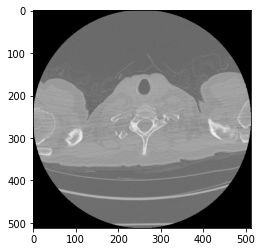

In [6]:
plt.imshow(img,cmap='gray')

In [7]:
mask=plt.imread('../input/chest-ct-segmentation/masks/masks/ID00007637202177411956430_mask_0.jpg')
mask.shape                    

(512, 512, 3)

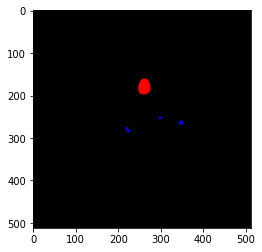

In [8]:
plt.imshow(mask)

In [9]:
mask

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [10]:

from keras.preprocessing.image import ImageDataGenerator
# we create two instances with the same arguments

# VI Note: use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1./255,
                    validation_split = 0.2)

mask_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1./255,
                    validation_split = 0.2)
                    

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**mask_gen_args) 

In [11]:
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

data_path='../input/chest-ct-segmentation/'
batch_sz=16
image_generator = image_datagen.flow_from_dataframe(
    dataframe=data,
    directory='../input/chest-ct-segmentation/images/images',
    class_mode=None,
    #classes=['images'],
    x_col='ImageId',
    seed=seed,
    color_mode='grayscale',
    batch_size=batch_sz,
    target_size=(256,256),
    subset='training'
)

Found 13367 validated image filenames.


In [12]:
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

data_path='../input/chest-ct-segmentation/'
batch_sz=16
image_generator_val = image_datagen.flow_from_dataframe(
    dataframe=data,
    directory='../input/chest-ct-segmentation/images/images',
    class_mode=None,
    #classes=['images'],
    x_col='ImageId',
    seed=seed,
    color_mode='grayscale',
    batch_size=batch_sz,
    target_size=(256,256),
    subset='validation'
)

Found 3341 validated image filenames.


In [13]:
mask_generator = mask_datagen.flow_from_dataframe(
    dataframe=data,
    directory='../input/chest-ct-segmentation/masks/masks',
    #classes=['masks'],
    class_mode=None,
    x_col='MaskId',
    seed=seed,
    batch_size=batch_sz,
    color_mode='rgb',
    target_size=(256,256),
    subset='training')

Found 13367 validated image filenames.


In [14]:
mask_generator_val = mask_datagen.flow_from_dataframe(
    dataframe=data,
    directory='../input/chest-ct-segmentation/masks/masks',
    #classes=['masks'],
    class_mode=None,
    x_col='MaskId',
    seed=seed,
    batch_size=batch_sz,
    color_mode='rgb',
    target_size=(256,256),
    subset='validation')

Found 3341 validated image filenames.


In [15]:
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)
def train_generator_fn():
    for (img,mask) in train_generator:
        yield (img,mask)        

In [16]:
# combine generators into one which yields image and masks
valid_generator = zip(image_generator_val, mask_generator_val)
def valid_generator_fn():
    for (img,mask) in valid_generator:
        yield (img,mask)        

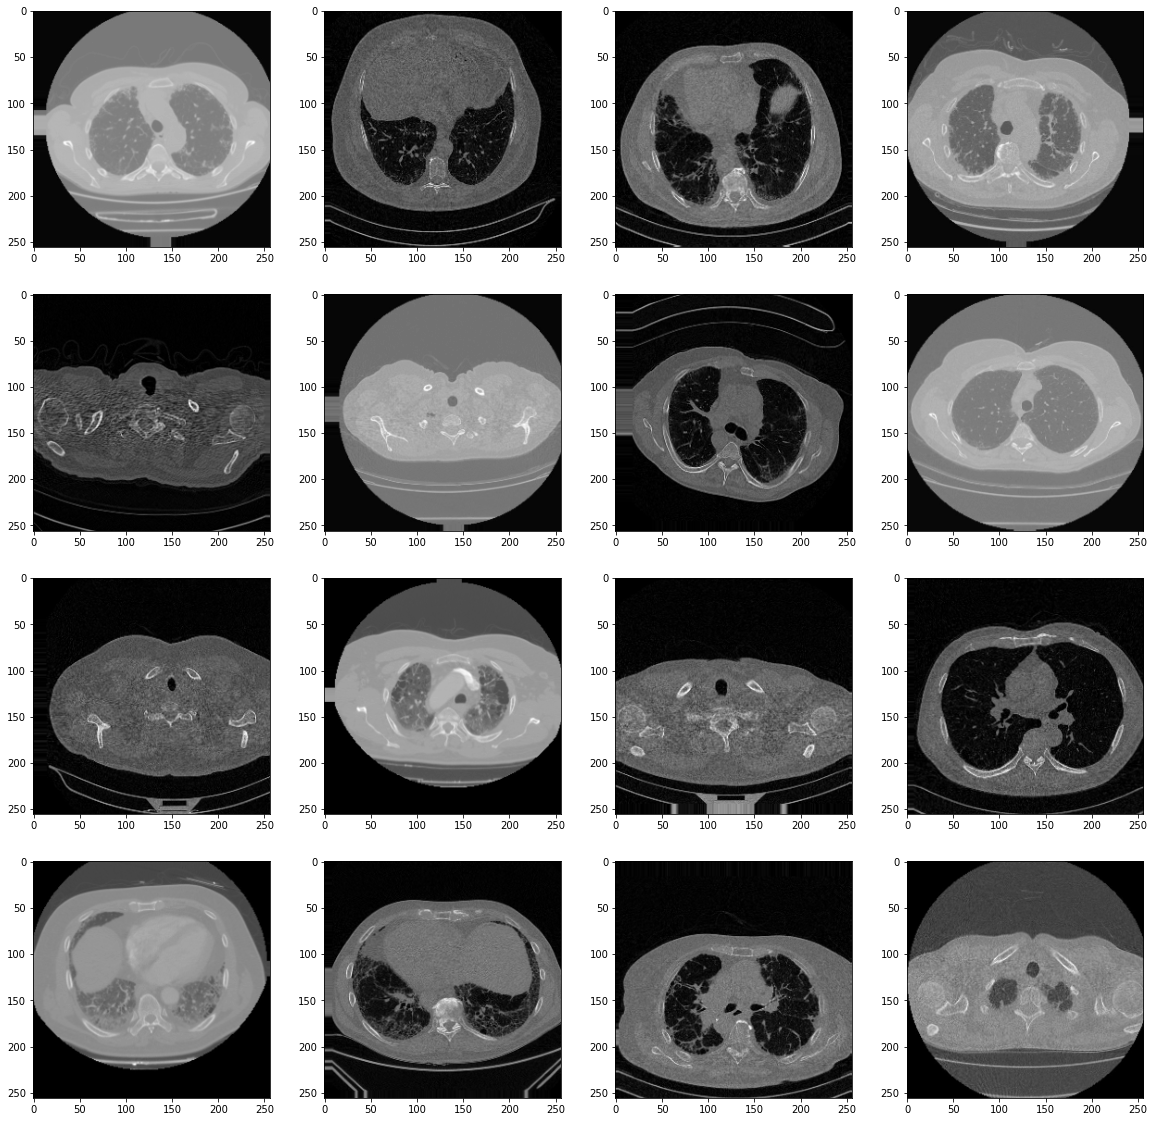

In [17]:
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i],cmap='gray')
    # show the plot
    plt.show()
    break

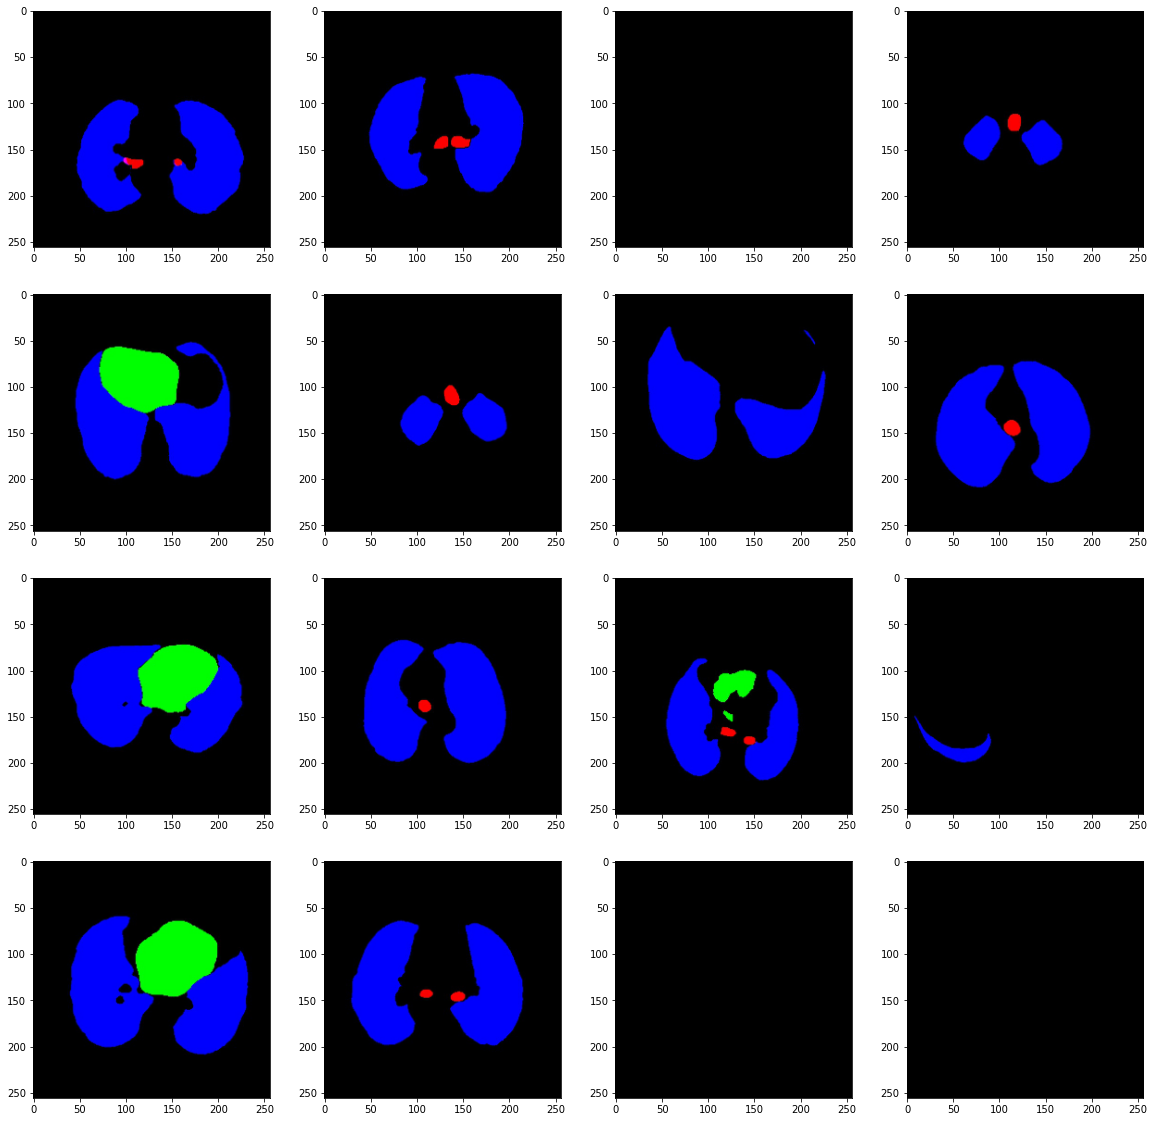

In [18]:
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(y_batch[i])
    # show the plot
    plt.show()
    break

In [19]:
def unet(n_classes,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    x = UpSampling2D(size = (2,2))(drop5)
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    conv10 = Conv2D(n_classes, (1,1), padding='same')(conv9)
    
    output_layer = Activation('softmax')(conv10)
     

    model = Model(inputs = inputs, outputs = output_layer)

    return model

In [20]:
model = unet(n_classes=3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [21]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [22]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_loss',verbose=2,factor=0.5,min_lr=0.00001)
model_checkpoint = ModelCheckpoint('unet_camvid.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_checkpoint]

In [23]:
model.compile(optimizer=Adam(learning_rate = 1e-4), loss=bce_dice_loss, metrics=[iou, dice_coef])

In [24]:

model.fit(train_generator_fn(),
                    validation_data=valid_generator_fn(),
                    steps_per_epoch=500,
                    validation_steps=10,
                    epochs=5,
                    callbacks=callback)

Epoch 1/5


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


500/500 [==============================] - 293s 555ms/step - loss: 0.8837 - iou: 0.1019 - dice_coef: 0.1842 - val_loss: 0.9042 - val_iou: 0.0785 - val_dice_coef: 0.1449

Epoch 00001: val_loss improved from inf to 0.90418, saving model to unet_camvid.hdf5
Epoch 2/5
500/500 [==============================] - 269s 538ms/step - loss: 0.8448 - iou: 0.1094 - dice_coef: 0.1964 - val_loss: 0.8867 - val_iou: 0.0848 - val_dice_coef: 0.1557

Epoch 00002: val_loss improved from 0.90418 to 0.88666, saving model to unet_camvid.hdf5
Epoch 3/5
500/500 [==============================] - 252s 504ms/step - loss: 0.8393 - iou: 0.1097 - dice_coef: 0.1969 - val_loss: 0.8982 - val_iou: 0.0773 - val_dice_coef: 0.1424

Epoch 00003: val_loss did not improve from 0.88666
Epoch 4/5
500/500 [==============================] - 252s 503ms/step - loss: 0.8363 - iou: 0.1088 - dice_coef: 0.1954 - val_loss: 0.8951 - val_iou: 0.0820 - val_dice_coef: 0.1502

Epoch 00004: val_loss did not improve from 0.88666
Epoch 5/5
500/

Text(0.5, 1.0, 'Dice Coef')

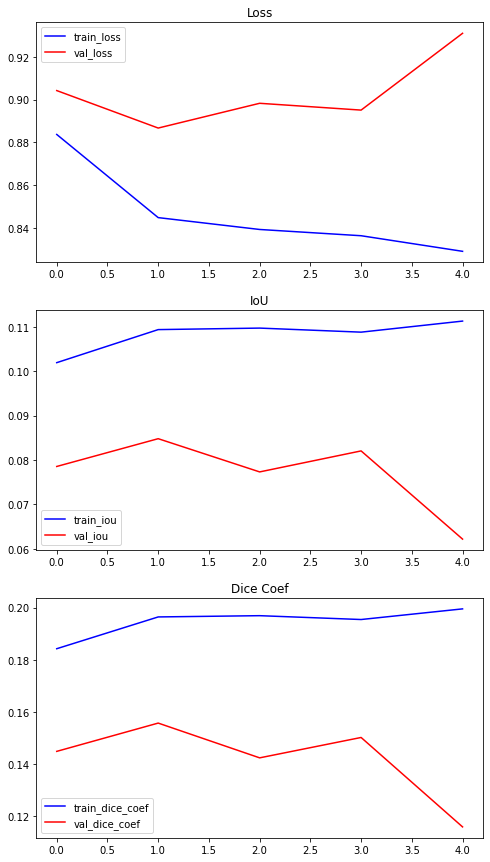

In [25]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(model.history.history['loss'], 'b-', label='train_loss')
plt.plot(model.history.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.title('Loss')

plt.subplot(3,1,2)
plt.plot(model.history.history['iou'], 'b-', label='train_iou')
plt.plot(model.history.history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.title('IoU')

plt.subplot(3,1,3)
plt.plot(model.history.history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(model.history.history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.title('Dice Coef')

In [26]:
test=plt.imread('../input/chest-ct-segmentation/images/images/ID00007637202177411956430_11.jpg')

In [27]:
test.shape

(512, 512)

In [28]:
test=cv2.resize(test,(256,256))
test=test/255.0

In [29]:
test.shape

(256, 256)

In [30]:
test=np.expand_dims(test,axis=0)

In [31]:
import numpy as np

# Assuming 'test' is your input data with shape (None, 1, 256, 256)
# Expand dimensions to match the expected input shape of the model
test = np.expand_dims(test, axis=-1)

# Now 'test' has shape (None, 1, 256, 256, 1) and can be used for prediction

# Perform prediction
pred = model.predict(test)

# Access the shape of 'pred'
print(pred.shape)



(1, 256, 256, 3)


In [32]:
pred.shape

(1, 256, 256, 3)

In [33]:
pred=pred.reshape(256,256,3)

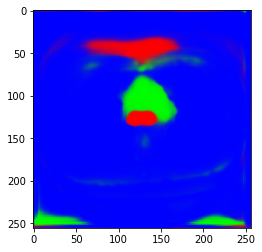

In [34]:
plt.imshow(pred)

In [35]:
mask=plt.imread('../input/chest-ct-segmentation/masks/masks/ID00007637202177411956430_mask_11.jpg')

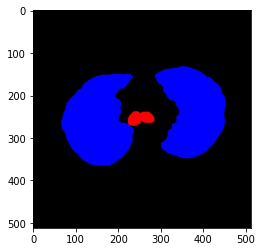

In [36]:
plt.imshow(mask)

In [37]:
import numpy as np

# Assuming you have your data stored in 'data' with shape (num_samples, height, width, channels)

# Compute the maximum value across all photos
max_value = np.max(data)

print("Maximum value:", max_value)


Maximum value: ImageId         ID00426637202313170790466_99.jpg
MaskId     ID00426637202313170790466_mask_99.jpg
dtype: object


In [38]:
import numpy as np

# Assuming x and y are your input and label/mask data, respectively
x = np.array([[[[1, 2], [3, 4]], [[5, 6], [7, 8]]]])  # Example input data
y = np.array([[[[0, 1], [1, 0]], [[0, 0], [1, 1]]]])  # Example label/mask data


In [44]:
import os
os.makedirs('3d_plot_frames', exist_ok=True)

In [42]:
# Example true labels and predicted labels
y_true = [0, 1, 1, 0, 1]  # True labels
y_pred = [0, 1, 0, 0, 1]  # Predicted labels

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)



Confusion Matrix:
[[2 0]
 [1 2]]


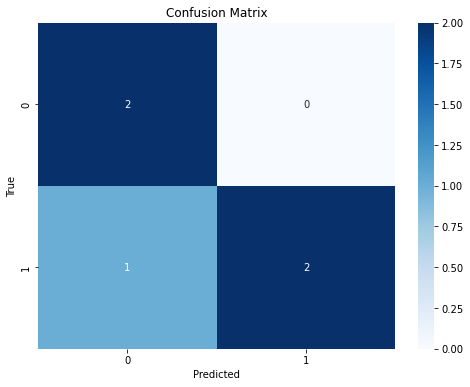

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example true labels and predicted labels
y_true = [0, 1, 1, 0, 1]  # True labels
y_pred = [0, 1, 0, 0, 1]  # Predicted labels

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
